CPS-based estimate of employment-population ratio
=====

## EPOPs for Various Groups by Gender, Age, Education

-----

*September 13, 2017*<br>
*Brian Dew, dew@cepr.net*

This notebook aims to calculate the employment to population ratio for each year since 1980 for each group by gender, age (16-24, 25-34, 35-44, 45-54, 55-64, and 65+), and education (less than high school, high school diploma, some college, college, advanced degress).

The source data is the [CEPR uniform data extracts based on the CPS Outgoing Rotation Group (ORG)](http://ceprdata.org/cps-uniform-data-extracts/cps-outgoing-rotation-group/). 

Separately, 2017 figures (preliminary) through August are obtained from the CPS FTP pages. The education variable is adjusted to match with the CEPR extracts as shown in [this file](C:/Working/Python/CPS/CPS_Monthly.ipynb).

See EPOPS_example.ipynb as a proof of concept that the basic strategy for summarizing the microdata from the CPS will match with the BLS summary statistics.

In [1]:
import pandas as pd
import numpy as np
import os
import itertools

#os.chdir('/home/domestic-ra/Working/CPS_ORG/EPOPs/')
os.chdir('C:\Working\Dropbox (CEPR)\homestata\Brian\SP01-Blaming_Men')

In [2]:
# Identify which columns to keep from the full CPS
cols = ['year', 'female', 'age', 'educ', 'empl', 'orgwgt']
gender = [('Male', 0), ('Female', 1)]
years = range(1979, 2018) # Year range, ending year add one. 
# Age groups (110 used just as max value)
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 110), 
        (16, 110), (25, 54)]
# Education level
educs = [['LTHS'], ['HS'], ['Some college'], ['College'], ['Advanced'], 
         ['LTHS', 'HS'], ['College', 'Advanced']]

#### Looping through CEPR CPS ORG datasets and storing results

Filter by criteria listed above to identify the weighted total and employed populations for each group. Next calculate ratio of employed to population.

In [3]:
data = pd.DataFrame()
demog = pd.DataFrame()
st = pd.DataFrame()
for y in years:
    yr = pd.to_datetime('{}-01-01'.format(y))
    filename = 'Data/cepr_org_{}.dta'.format(y)   # Read CEPR ORG .dta file
    df = pd.read_stata(filename, columns=cols).dropna()
    tot_pop = df['orgwgt'].sum()
    for args in itertools.product(gender, ages, educs):
        # Generate subgroup description column name (cname)
        age = '-'.join(str(arg) for arg in args[1])
        if args[1][1] == 110: age = '{}+'.format(args[1][0])
        cname = '{}: {}: {}'.format(args[0][0], age, ' or '.join(args[2]))
        # filter CPS to subgroup and calculate epop
        dft = df[(df['age'] >= args[1][0]) & (df['age'] <= args[1][1]) &
                (df['female'] == args[0][1]) & (df['educ'].isin(args[2]))]    
        epop = np.average(dft['empl'].astype(float), weights=dft['orgwgt']) * 100
        # Add the epop and share of total population to dataframes
        data.set_value(yr, cname, epop)
        demog.set_value(yr, cname, (dft['orgwgt'].sum() / tot_pop) * 100)

C:\Users\BDew\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\BDew\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


#### Summarizing the results over key periods

Compute the period averages and percent change for:

* 1979-1988
* 1988-2000
* 2000-2015
* 2015-2017(p)

In [4]:
sdates = [('1979-01-01', '1988-01-01'), ('1988-01-01', '2000-01-01'), 
          ('2000-01-01', '2015-01-01'), ('2015-01-01', '2017-01-01'),
          ('1979-01-01', '2017-01-01')]
for args in itertools.product(data.iteritems(), sdates):
    srange = '-'.join(arg[:4] for arg in args[1])
    # Calculate mean value for years in each sdate_range
    mean = args[0][1].loc[args[1][0]: args[1][1]].mean()
    # Calculate percentage point change from start to end
    ch = args[0][1].loc[args[1][1]] - args[0][1].loc[args[1][0]]
    # Add mean and change to summary table
    st.set_value(args[0][0], srange+' Mean', mean)
    st.set_value(args[0][0], srange+' Change', ch)

C:\Users\BDew\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\BDew\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


#### Save results to csv

In [5]:
for name, table in [('data', data), ('demog', demog), ('summary_table', st)]:
    table.to_csv('Results/EPOPS_{}.csv'.format(name))

#### Plotting the results

Generate a small plot of each EPOP rate

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
# There are more than 60 figures; turn off warning
mpl.rcParams.update({'figure.max_open_warning': 0})
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

%matplotlib inline

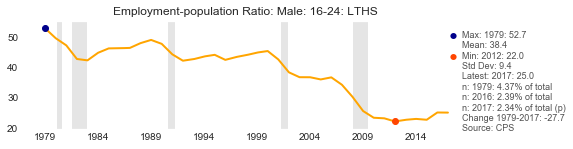

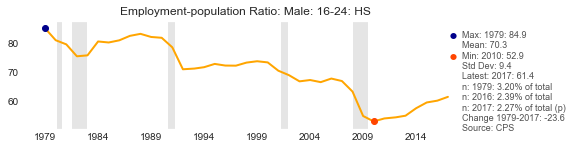

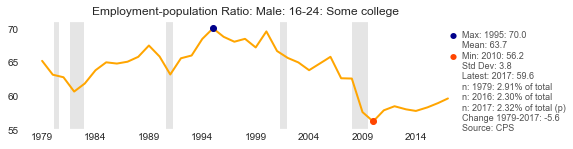

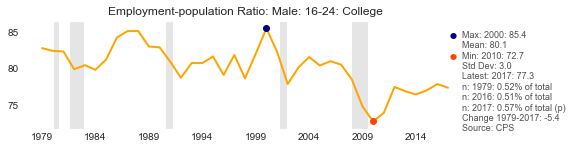

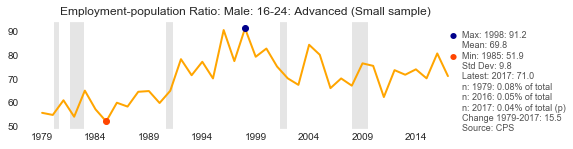

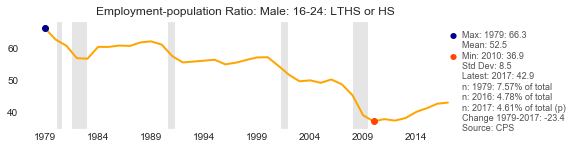

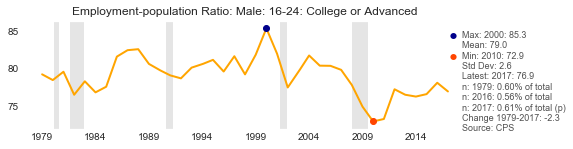

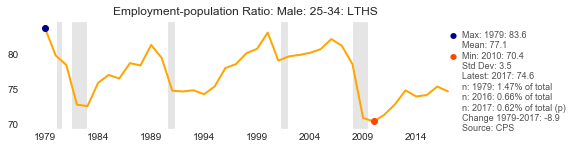

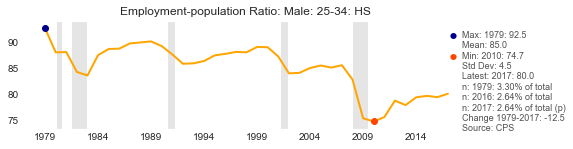

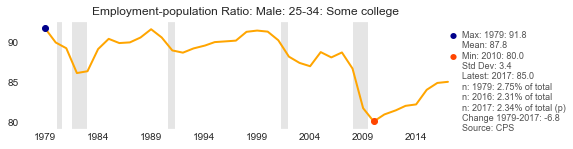

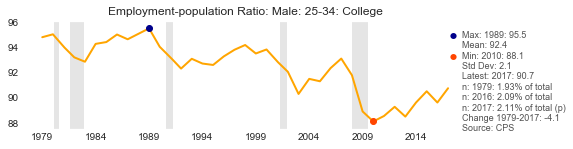

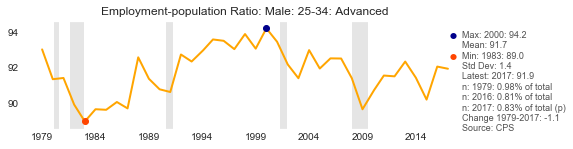

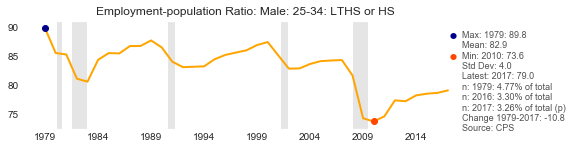

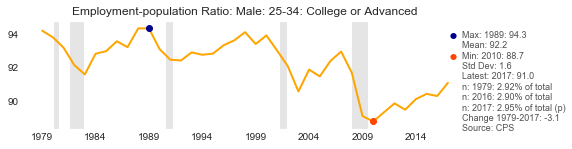

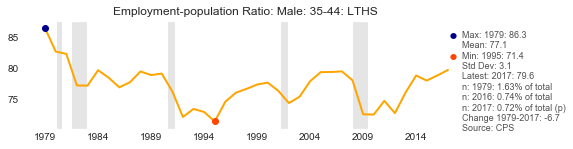

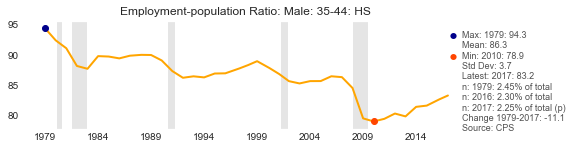

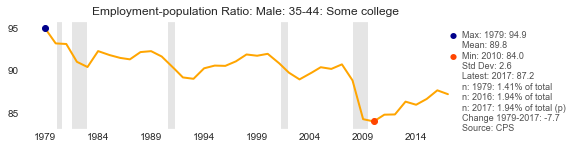

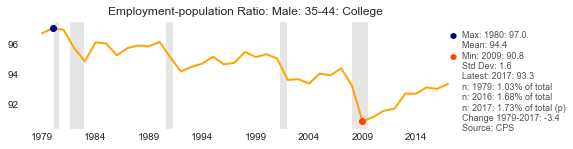

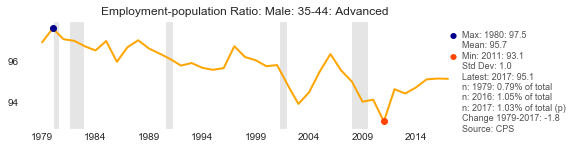

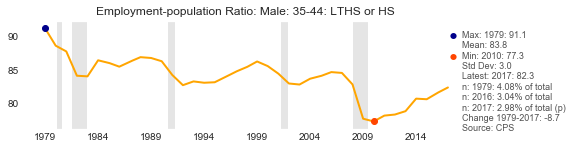

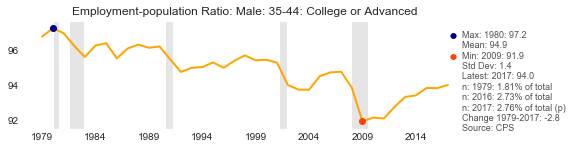

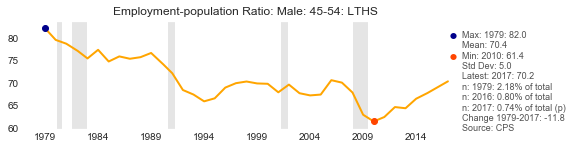

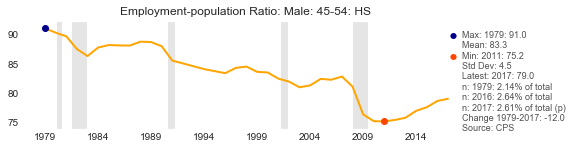

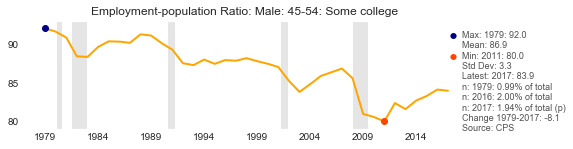

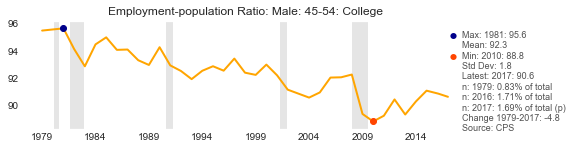

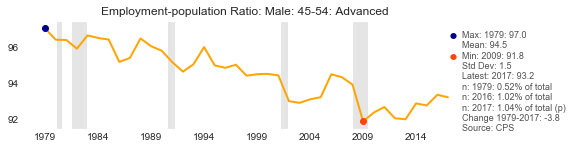

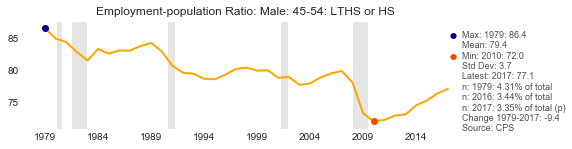

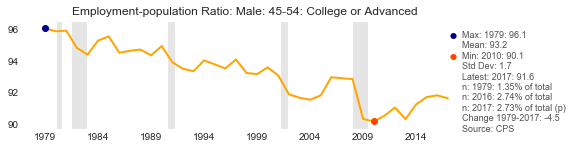

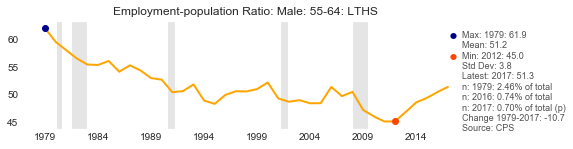

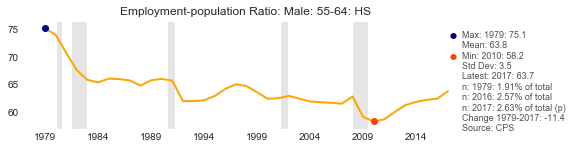

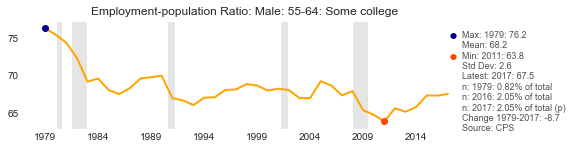

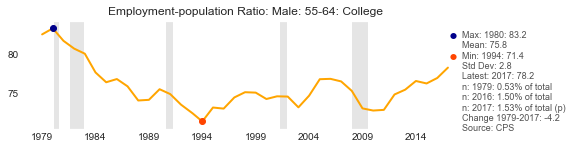

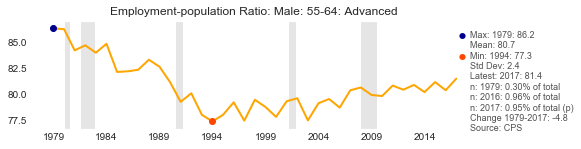

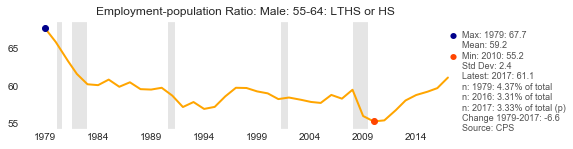

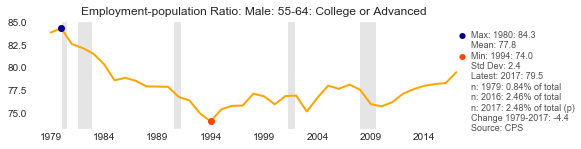

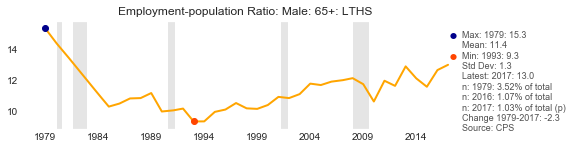

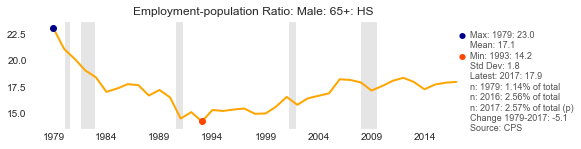

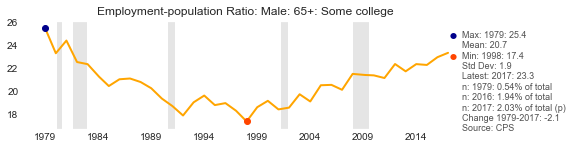

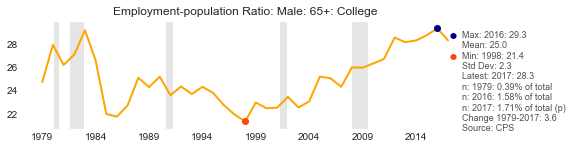

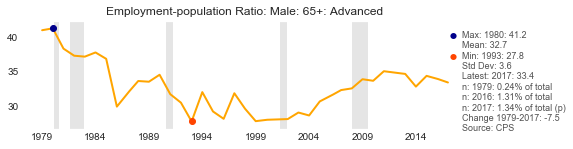

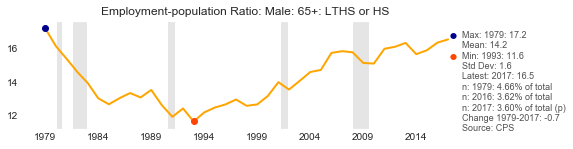

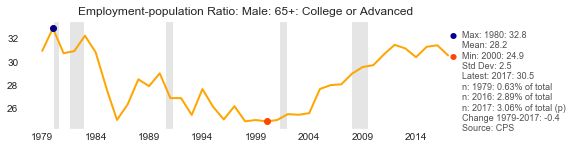

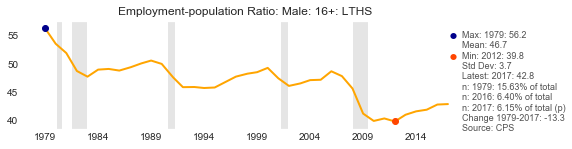

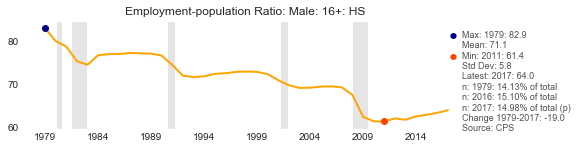

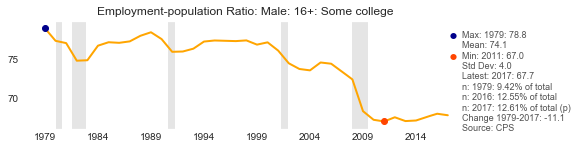

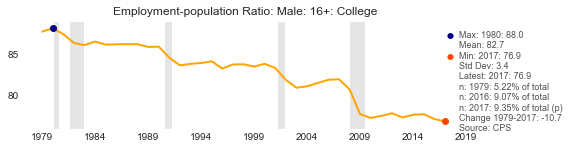

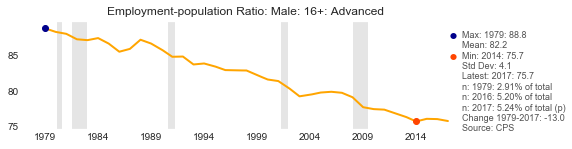

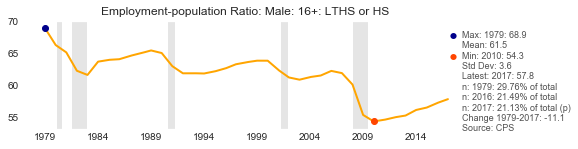

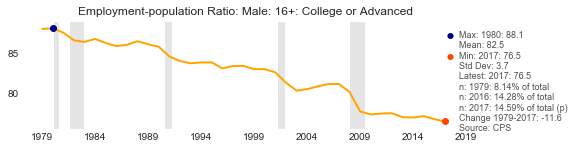

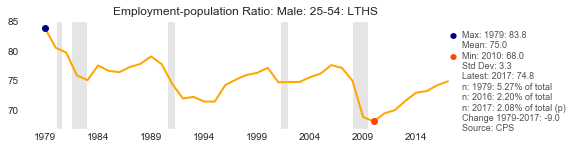

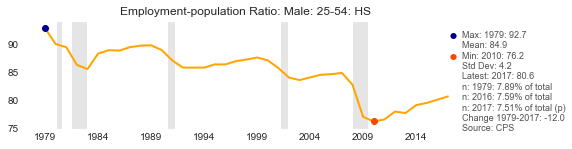

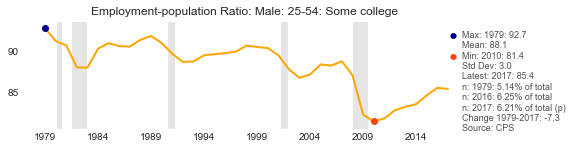

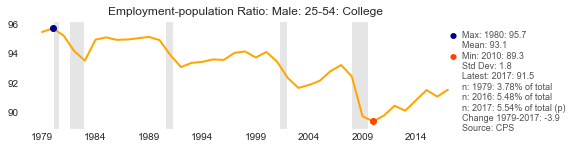

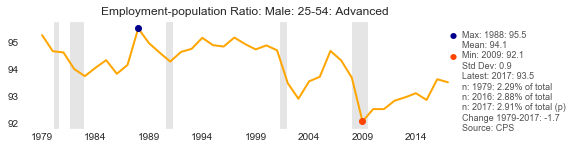

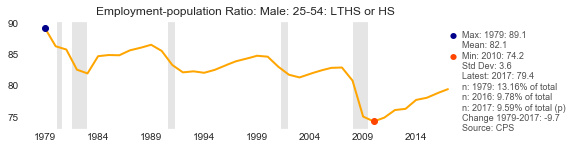

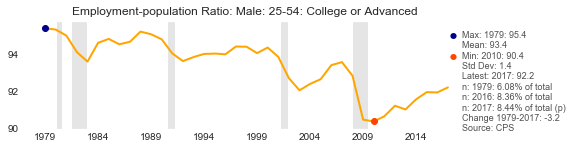

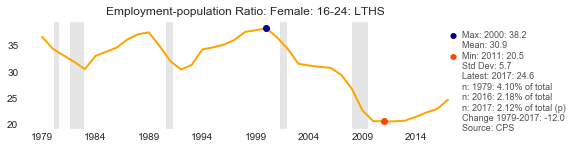

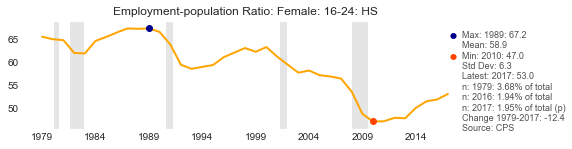

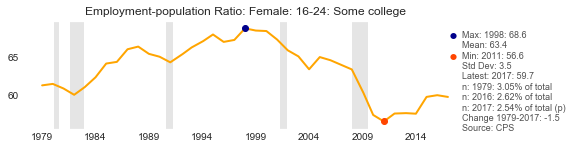

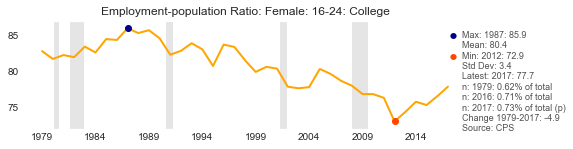

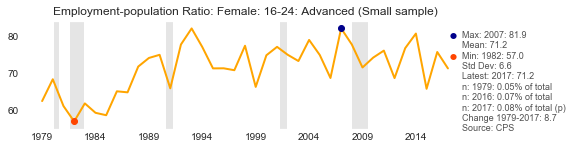

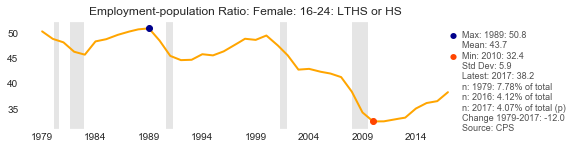

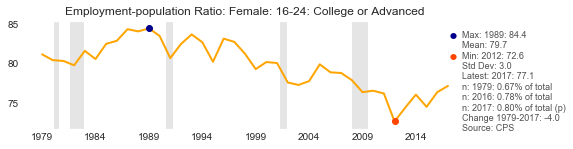

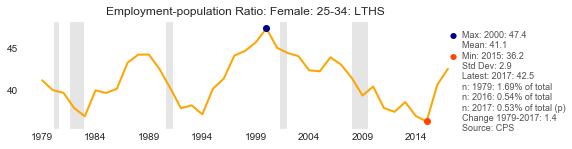

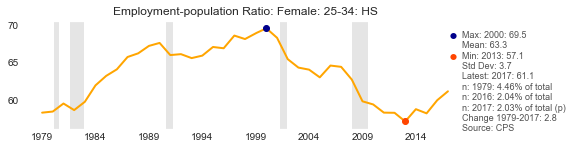

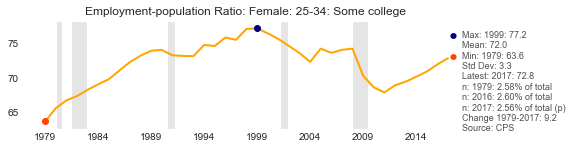

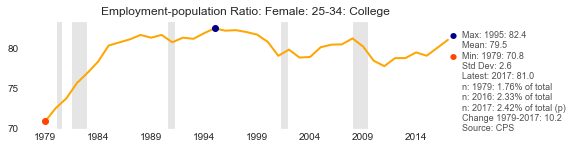

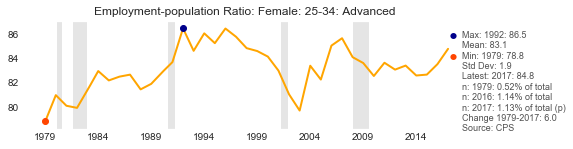

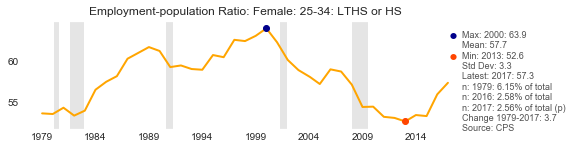

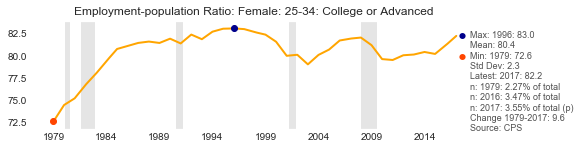

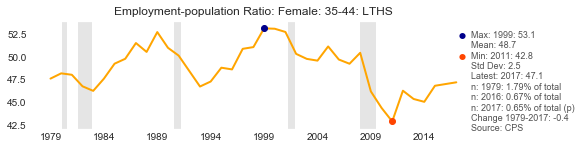

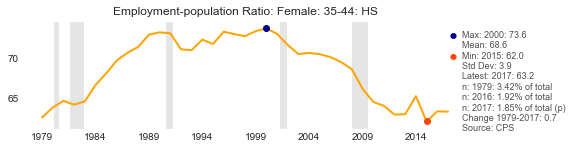

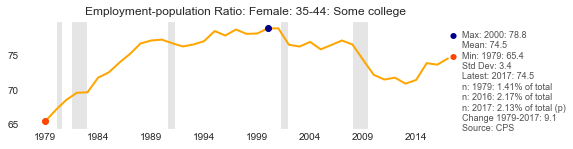

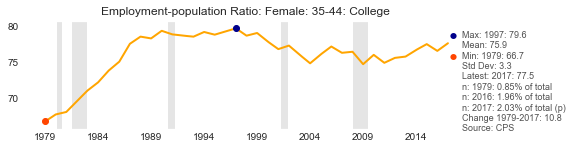

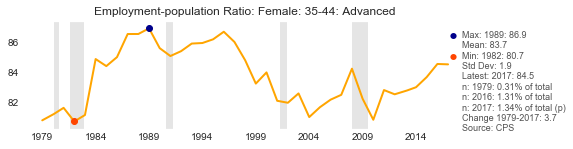

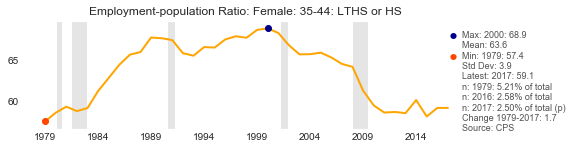

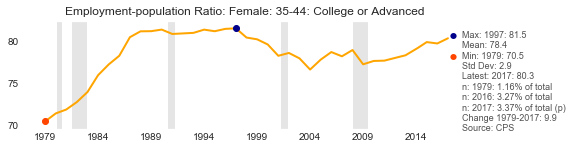

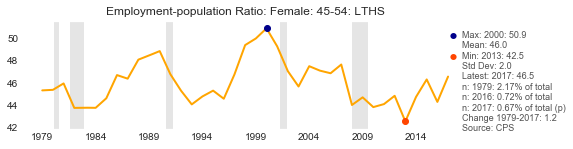

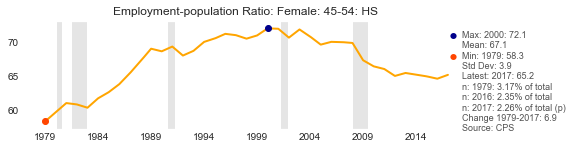

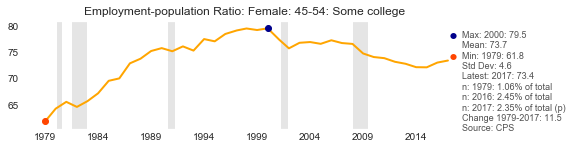

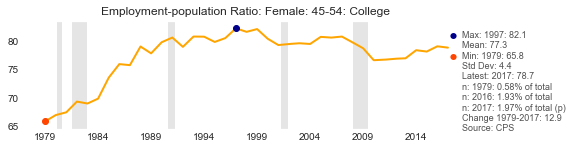

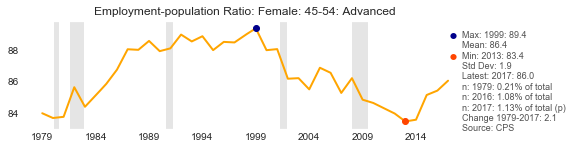

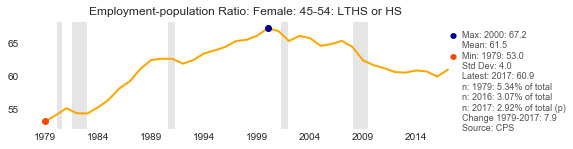

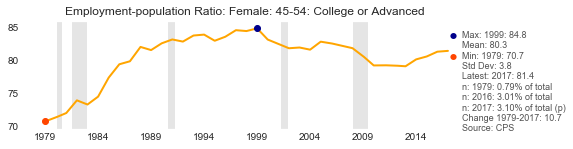

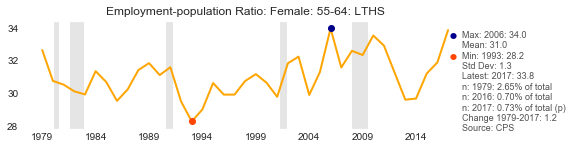

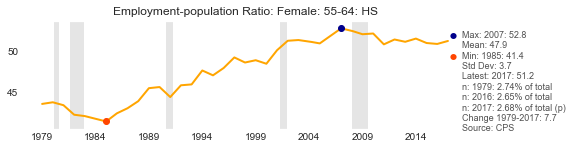

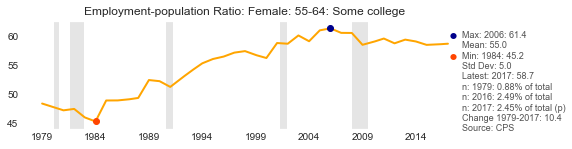

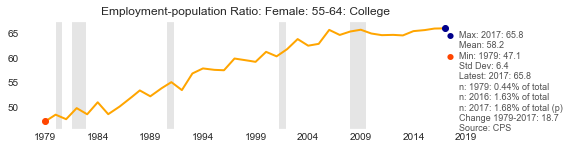

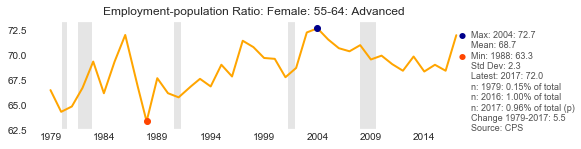

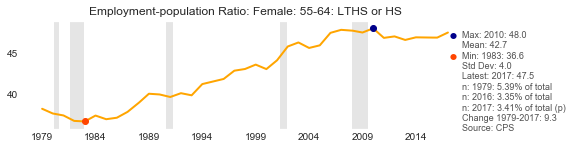

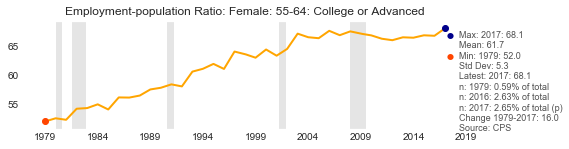

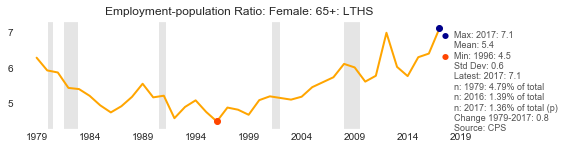

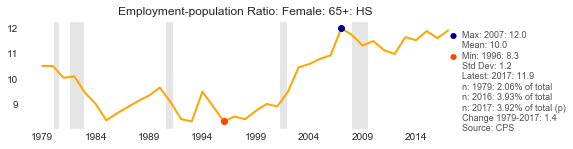

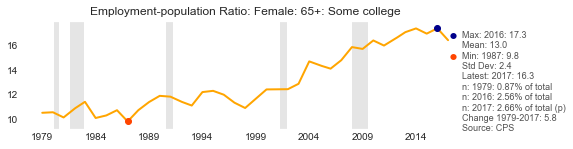

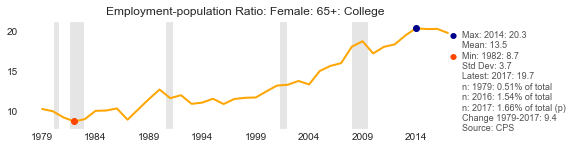

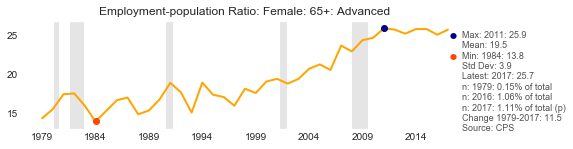

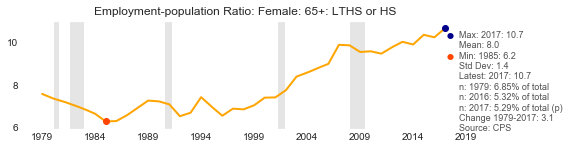

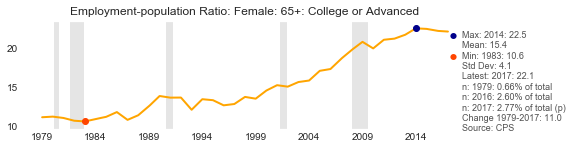

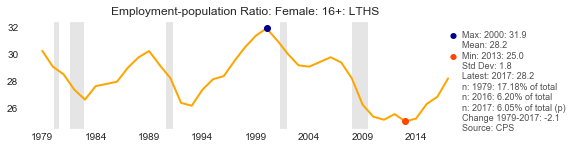

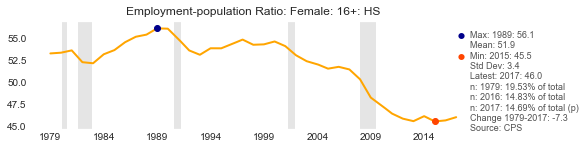

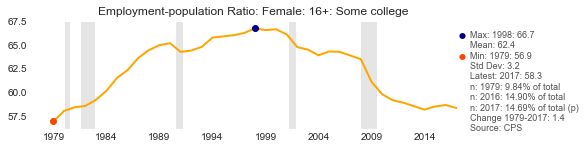

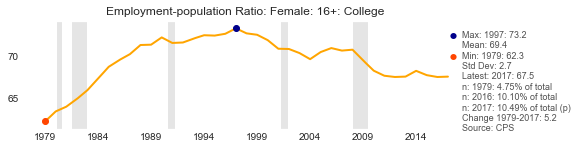

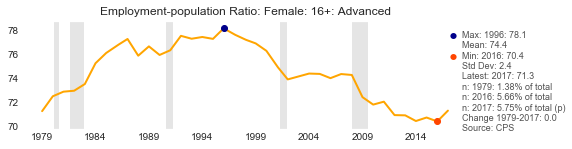

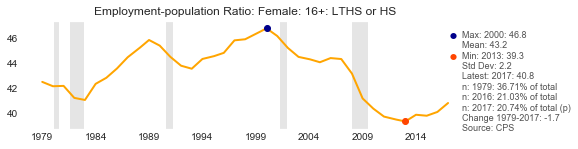

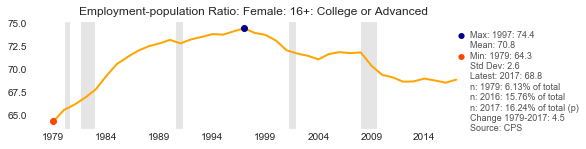

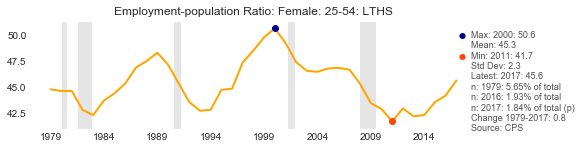

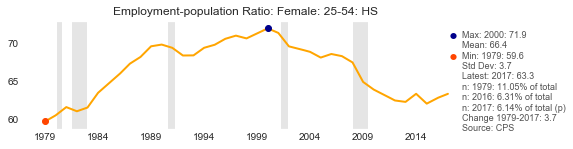

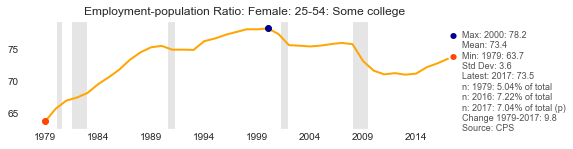

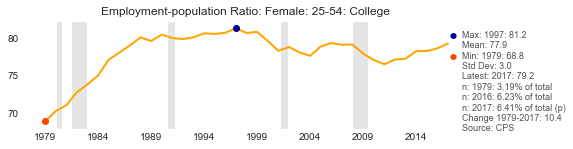

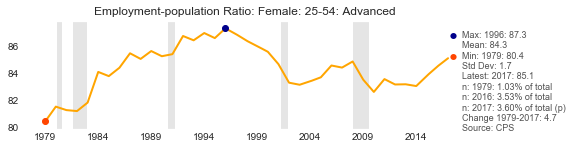

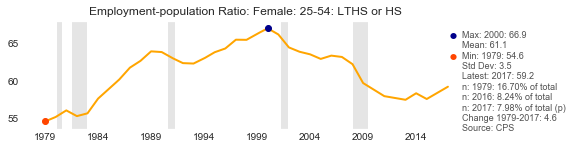

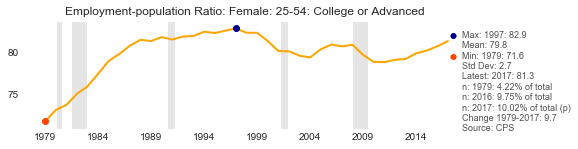

In [10]:
for name, values in data.iteritems():
    title = 'Employment-population Ratio: {}'.format(name)  # Title for graph
    if demog[name].iloc[-1] < 0.1:
        title = 'Employment-population Ratio: {} (Small sample)'.format(name)
    
    plt.figure()    # Plot series with max and min values marked
    values.resample('MS').interpolate(method='linear').plot(figsize=(8, 2), 
        title=title, zorder=1, color='orange', linewidth=2)
    plt.scatter(values.idxmax(), values.max(), color='darkblue', alpha=1, zorder=2)
    plt.scatter(values.idxmin(), values.min(), color='orangered', alpha=1, zorder=2)

    # Shaded bars indicating recessions
    for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
        plt.axvspan(v['peak'], v['trough'], fill=True, 
                    linewidth=0, color='gray', alpha=0.2)    

    # Plot labels and extra info
    maxv, maxy = round(values.max(),2), values.idxmax().year
    minv, miny = round(values.min(),2), values.idxmin().year  
    plt.text(565, maxv-0.17*(maxv-minv), u'\u2022', color='darkblue', fontsize=25)    
    plt.text(565, maxv-0.4*(maxv-minv), u'\u2022', color='orangered', fontsize=25)
    text =  '''Max: {}: {:0.1f}\nMean: {:0.1f}\nMin: {}: {:0.1f}\nStd Dev: {:0.1f}
Latest: {}: {:0.1f}\nn: {}: {:0.2f}% of total\nn: {}: {:0.2f}% of total
n: {}: {:0.2f}% of total (p)\nChange {}-{}: {:0.1f}\nSource: CPS'''.format(
        maxy, maxv, values.mean(), miny, minv, values.std(), years[-1], 
        values['{}-01-01'.format(years[-1])], years[0], demog[name].iloc[0],
        years[-2], demog[name].iloc[-2], years[-1], demog[name].iloc[-1],
        years[0], years[-1], (values[-1] - values[0]))
    plt.text(580, minv-0.1*(maxv-minv), text, size=9, alpha=0.8)